In [ ]:
import pandas as pd
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

In [ ]:
from eda.eda import correlation
from eda.visualization import *
import pydoop.hdfs as hd

# **1. Load data**

In [ ]:
data_path = 'hdfs://node-master:8020/user/hadoop/WA_Fn-UseC_-HR-Employee-Attrition.csv'
schema_fields = []

In [ ]:
spark = SparkSession.builder.master("spark://node-master:7077").appName("Employee_Attrition").getOrCreate()

with hd.open(data_path) as f:
    data =  pd.read_csv(f)

2023-02-06 10:18:11,518 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
for col_index in range(data.shape[1]):
  field_name = data.columns[col_index]
  field_type = data.dtypes[col_index]

  if field_type == 'int64':
    schema_fields.append(
        StructField(field_name, FloatType(), nullable = True)
    )
  elif field_type == 'object':
        schema_fields.append(
        StructField(field_name, StringType(), nullable = True)
    )

df = spark.read.csv(path=data_path, schema= StructType(schema_fields)).cache()

23/02/06 10:18:20 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [ ]:
df = spark.read.csv(path=data_path, schema= StructType(schema_fields)).cache()
df = df.where(df.EmployeeNumber.isNotNull())

df = df.where(df.EmployeeNumber.isNotNull())
df.show()

23/02/06 10:18:20 WARN CacheManager: Asked to cache already cached data.


23/02/06 10:18:36 WARN TaskSchedulerImpl: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
23/02/06 10:18:51 WARN TaskSchedulerImpl: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
23/02/06 10:19:06 WARN TaskSchedulerImpl: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
23/02/06 10:19:21 WARN TaskSchedulerImpl: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources


23/02/06 10:19:36 WARN TaskSchedulerImpl: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
23/02/06 10:19:51 WARN TaskSchedulerImpl: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
23/02/06 10:20:06 WARN TaskSchedulerImpl: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources


+----+---------+-----------------+---------+--------------------+----------------+---------+--------------+-------------+--------------+-----------------------+------+----------+--------------+--------+--------------------+---------------+-------------+-------------+-----------+------------------+------+--------+-----------------+-----------------+------------------------+-------------+----------------+-----------------+---------------------+---------------+--------------+------------------+-----------------------+--------------------+
| Age|Attrition|   BusinessTravel|DailyRate|          Department|DistanceFromHome|Education|EducationField|EmployeeCount|EmployeeNumber|EnvironmentSatisfaction|Gender|HourlyRate|JobInvolvement|JobLevel|             JobRole|JobSatisfaction|MaritalStatus|MonthlyIncome|MonthlyRate|NumCompaniesWorked|Over18|OverTime|PercentSalaryHike|PerformanceRating|RelationshipSatisfaction|StandardHours|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|WorkLifeBala

#**2 Explanatory Data Analysis**

##**2.1 Overview of the data**

Brief summary of the data, which have number of not null value, mean, standard derivation, min, max for each coulumn and first quantile, mean and third quantile for numeric column.  
Observing this summray table, there is not null value in the dataset.

In [ ]:
df.summary().show()

+-------+------------------+---------+--------------+------------------+---------------+----------------+------------------+----------------+-------------+-----------------+-----------------------+------+------------------+------------------+------------------+--------------------+------------------+-------------+-----------------+------------------+------------------+------+--------+------------------+-------------------+------------------------+-------------+------------------+------------------+---------------------+------------------+------------------+------------------+-----------------------+--------------------+
|summary|               Age|Attrition|BusinessTravel|         DailyRate|     Department|DistanceFromHome|         Education|  EducationField|EmployeeCount|   EmployeeNumber|EnvironmentSatisfaction|Gender|        HourlyRate|    JobInvolvement|          JobLevel|             JobRole|   JobSatisfaction|MaritalStatus|    MonthlyIncome|       MonthlyRate|NumCompaniesWorked|O

For some columns, although the defined data type is numeric, but the number of unique values is small, e.g. JobSatisfaction, JobLevel, so we consider them as ordinal variables.  
Following is the defined variable types, which is used in Explanatory Data Analysis.

In [ ]:
discrete_attributes = ["NumCompaniesWorked", "TrainingTimesLastYear", ]
continous_attributes = ["Age", "DailyRate", "DistanceFromHome", "HourlyRate", "MonthlyIncome", 
                        "MonthlyRate", "PercentSalaryHike", "TotalWorkingYears",
                        "YearsAtCompany", "YearsInCurrentRole", "YearsSinceLastPromotion", "YearsWithCurrManager"]
numeric_attributes = discrete_attributes + continous_attributes

nominal_attributes = ["Department", "EducationField", 
                          "Gender", "JobRole", "MaritalStatus"]
ordinal_attributes = ["BusinessTravel", "Education", "EnvironmentSatisfaction", "JobInvolvement", 
                      "JobLevel", "JobSatisfaction", "PerformanceRating",  "OverTime", 
                      "RelationshipSatisfaction", "StockOptionLevel",
                      "WorkLifeBalance"]
categorical = nominal_attributes + ordinal_attributes

target_name = "Attrition"

Since each employee has unique EmployeeNumber, and all of them are over 18, have the same StandarHours, EmployeeCount, we will drop these columns.

In [ ]:
for att_name in ['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours']:
  print("{}, number of unique value: {}".format(att_name, df.select(att_name).distinct().count()))

df = df.drop(*['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours'])

EmployeeCount, number of unique value: 1
EmployeeNumber, number of unique value: 1470
Over18, number of unique value: 1
StandardHours, number of unique value: 1


In [ ]:
df.groupBy('Attrition').count().show()

+---------+-----+
|Attrition|count|
+---------+-----+
|       No| 1233|
|      Yes|  237|
+---------+-----+



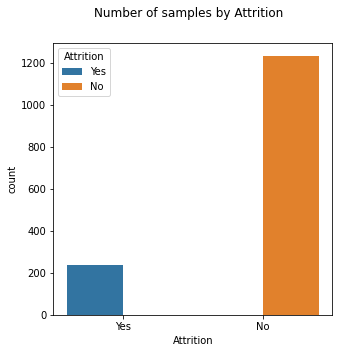

In [ ]:
 fig, ax = plt.subplots(1, 1)
 fig.set_size_inches(5, 5)

 selected_data = df.select([target_name]).collect()
 selected_data = pd.DataFrame(selected_data, columns= [target_name])

sns.countplot(data= selected_data, x= target_name, hue = target_name, ax = ax)

fig.suptitle("Number of samples by Attrition")
plt.show()

##**2.1 Correlation**

Spearman correlation heatmap of numeric and ordrinal variables. We maek the upper part of heat map for better seeing.    
</br></br>Some obvious insights can be seen from the correlation heatmap is that JobLevel is highly corerlated with MonthyIncome. One group or attributes which has high correlation is TotalWorkingYear, YearAtCompany, YearsInCurrentRole and YearsWithCurrManager.  
</br></br>The target variables, Attrition, is not highly correlated with any other columns. However, it is slightly propotionally correlated with OverTime. In other words, employee who have to wotk over time is more likely to quit the job.
It also have small opposite correlation with Age, MonthlyIncome, TotalWorkingYear, YearsAtCompany, etc.

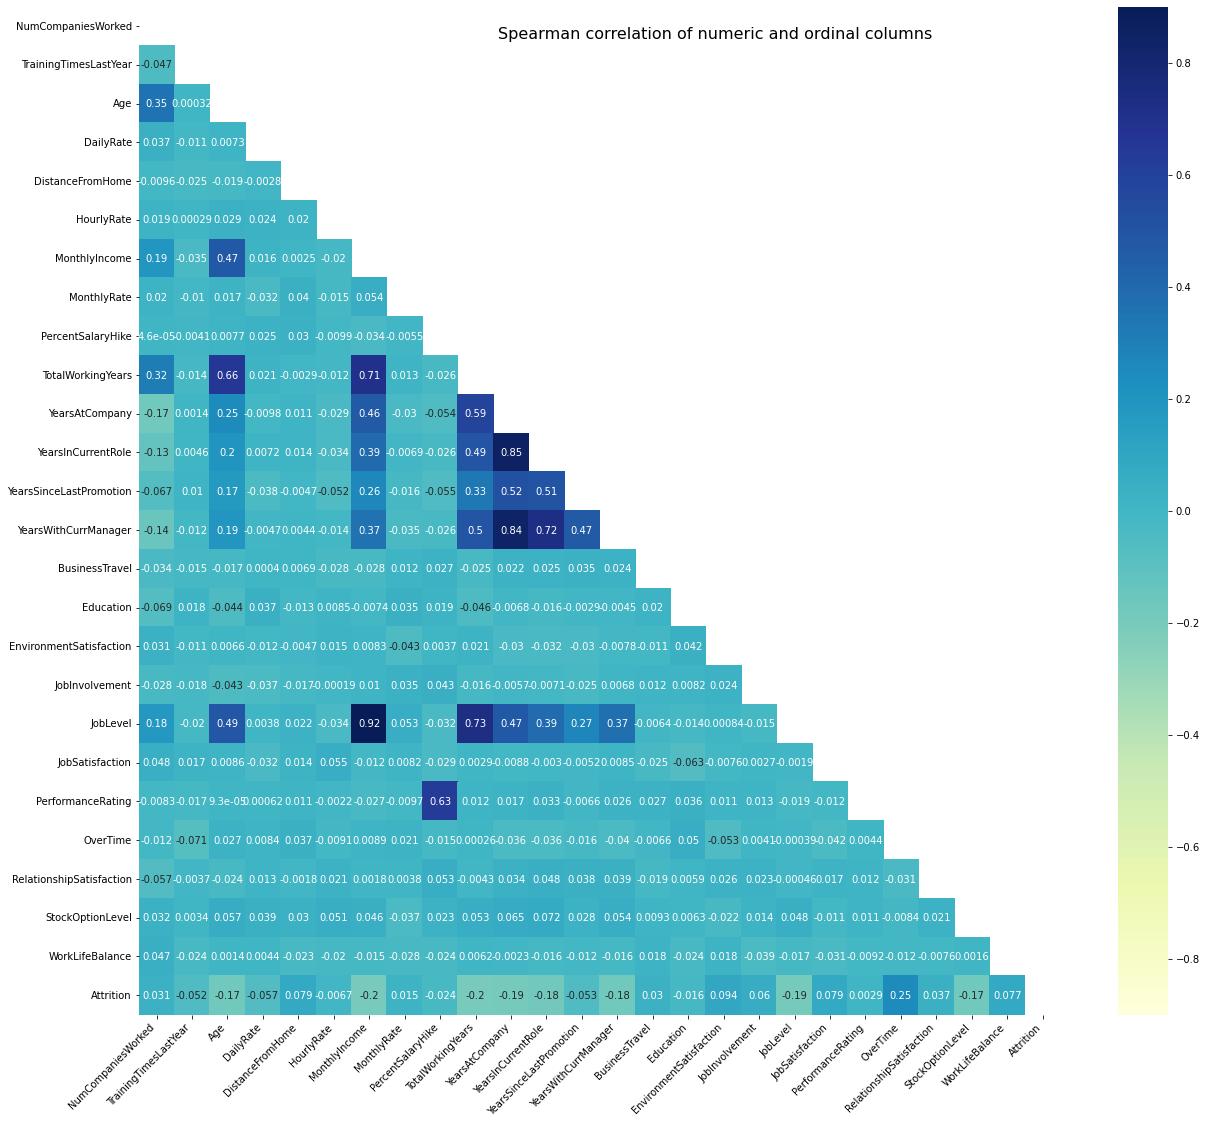

In [ ]:
fig = correlation_heatmap(df, ordinal_attributes, numeric_attributes, masked= True)
fig.suptitle("Spearman correlation of numeric and ordinal columns", size= 16)
plt.show()

##**2.2 Numeric variables**

In [ ]:
import importlib
import eda
importlib.reload(eda.visualization)

<module 'eda.visualization' from '/content/drive/MyDrive/Introduction to Business Analytics/eda/visualization.py'>

Below is box plot of continous variables, color represents Attrition. Some attributes have many outliers.

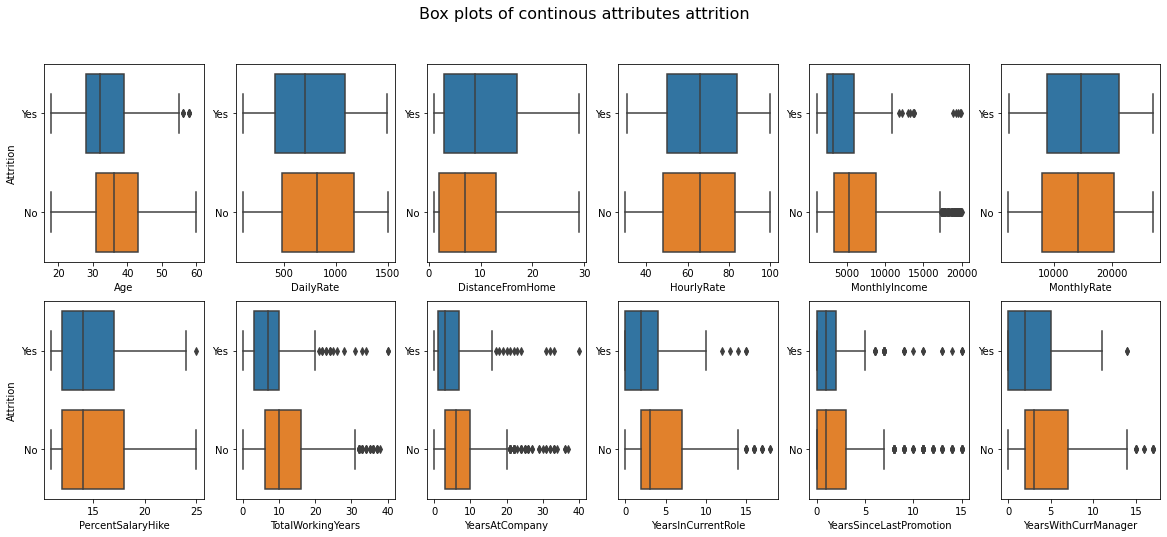

In [ ]:
fig = continous_plot(dataset= df, continous_attributes= continous_attributes, plot_type= 'boxplot')
fig.suptitle("Box plots of continous attributes attrition", size= 16)

plt.show()

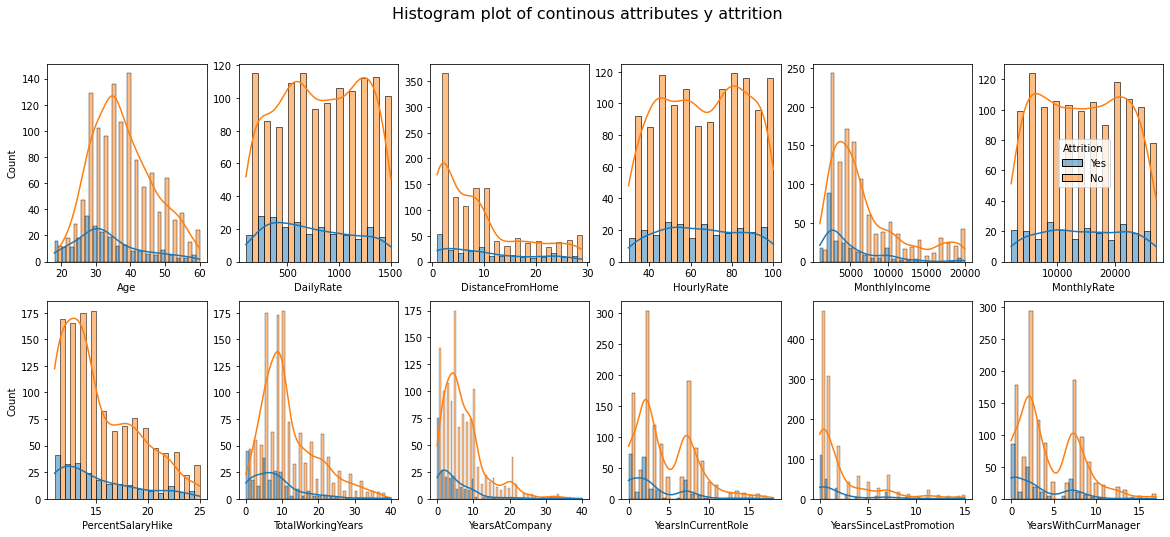

In [ ]:
fig = continous_plot(dataset= df, continous_attributes= continous_attributes, plot_type= 'histplot', grouped= True)
fig.suptitle("Histogram plot of continous attributes y attrition", size= 16)

plt.show()

## **2.3 Ordinal variables**

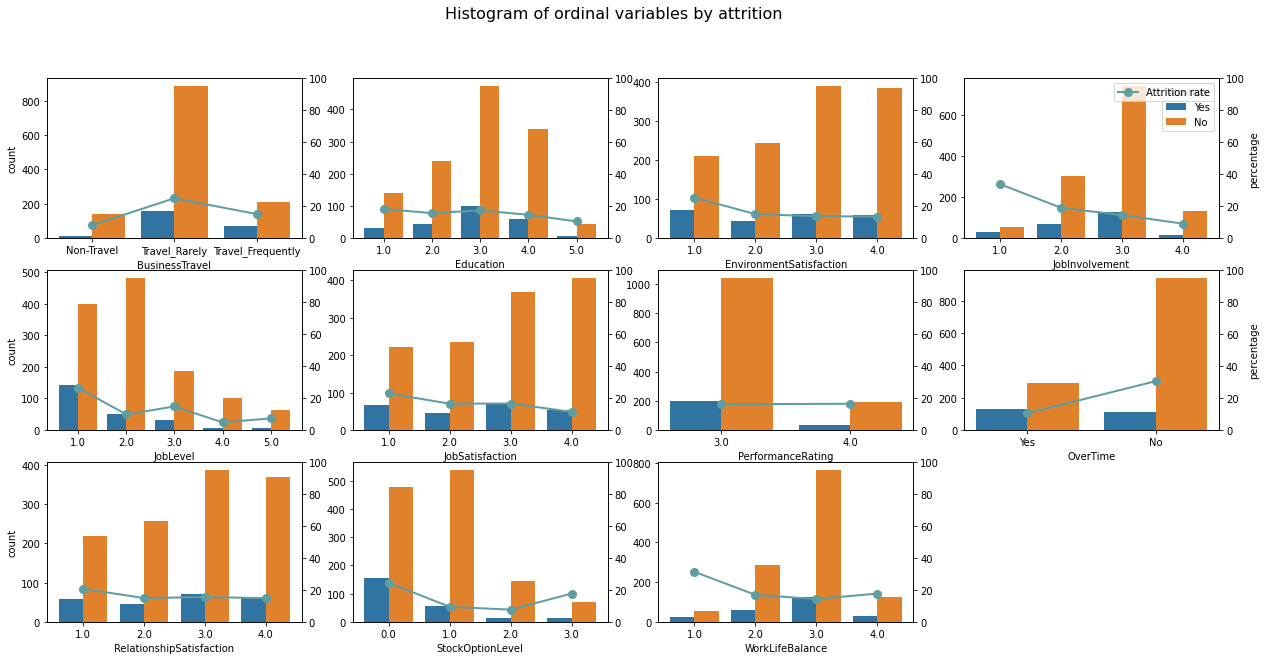

In [ ]:
fig = hist_ordinal(df, ordinal_attributes)
plt.show()

##**2.4 Nomial variables**

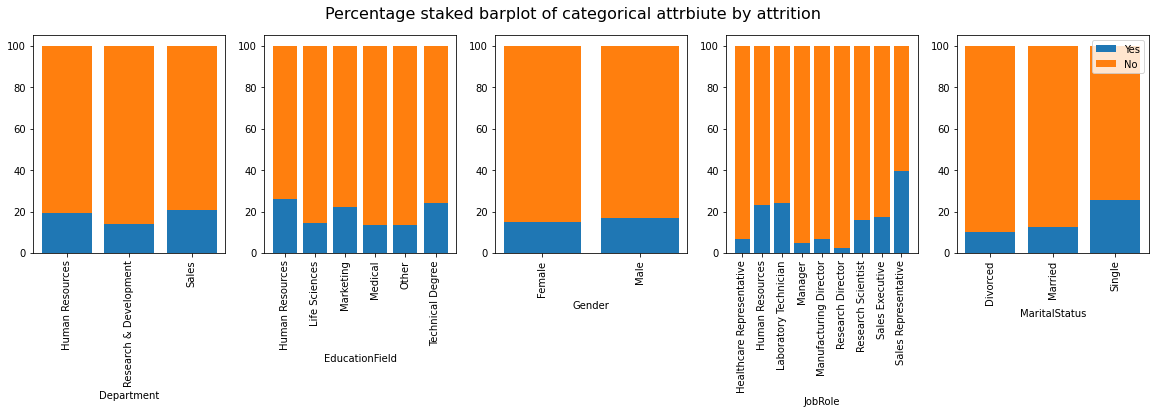

In [ ]:
fig = percentage_stacked(df, nominal_attributes, plot_type = 'countplot')
fig.suptitle("Percentage staked barplot of categorical attrbiute by attrition", size = 16)

plt.show()

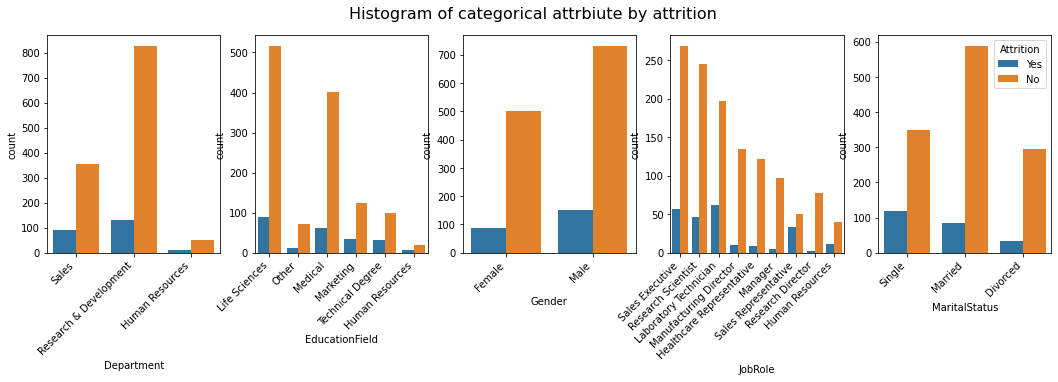

In [ ]:
fig = nominal_plot(df, nominal_attributes, plot_type = 'countplot')
fig.suptitle("Histogram of categorical attrbiute by attrition", size = 16)

plt.show()

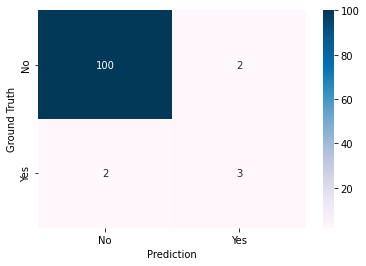

In [ ]:
confusion = np.array([[100, 2],
                      [2, 3]])
fig, ax = plt.subplots(1, 1)

sns.heatmap(confusion, annot= True, cmap="PuBu", ax = ax,  fmt= '.0f')
ax.set_xlabel("Prediction")
ax.set_xticklabels(["No", "Yes"])
ax.set_ylabel("Ground Truth")
ax.set_yticklabels(["No", "Yes"])

plt.show()